# Détection, segmentation et classification des déchets dans des environnements complexes (Med Habib Kammoun & Dhia Elhak Toukebri )

## 1. Installation du data

In [ ]:
!kaggle datasets download apremeyan/garbage
!pip install ultralytics
!git lfs install
!git clone https://huggingface.co/turhancan97/yolov8-segment-trash-detection

Dataset URL: https://www.kaggle.com/datasets/apremeyan/garbage
License(s): CC0-1.0
garbage.zip: Skipping, found more recently modified local copy (use --force to force download)
Git LFS initialized.
fatal: destination path 'yolov8-segment-trash-detection' already exists and is not an empty directory.


## 2. Extraire le fichier .zip du data

In [ ]:

import zipfile

# Chemin du fichier zip
zip_path = '/content/garbage.zip'

# Dossier où extraire les fichiers
extract_to = '/content/extracted_files'

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Fichiers extraits dans le dossier : {extract_to}")

Fichiers extraits dans le dossier : /content/extracted_files


## 3. Utulisation du YOLYOV8 pour la segmentation des objets

In [ ]:
def process_image(image_path, yolo_model, visualize=True, output_path="yolo_predictions.jpg"):
    """
    Processes an image to detect trash using YOLO and optionally visualize the results.

    Args:
        image_path (str): Path to the input image.
        yolo_model: YOLO model instance for prediction.
        visualize (bool): Whether to visualize and save the results.
        output_path (str): Path to save the visualization.

    Returns:
        list: A list of detections with bounding boxes and confidences.
    """
    from PIL import Image
    import cv2

    # Load the input image using PIL and OpenCV
    original_image_pil = Image.open(image_path).convert("RGB")
    original_image_cv = cv2.imread(image_path)

    # Perform YOLO prediction
    results = yolo_model.predict(source=image_path, save=False, imgsz=640, conf=0.5)
    detections = []

    # Extract bounding boxes and confidence scores from YOLO results
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            confidence = box.conf[0].item()
            detection = {"bbox": (x1, y1, x2, y2), "confidence": confidence}
            detections.append(detection)

            # Optionally visualize the detections on the image
            if visualize:
                color = (255, 0, 0)  # Blue color for bounding boxes
                cv2.rectangle(original_image_cv, (x1, y1), (x2, y2), color, 2)
                label = f"Conf: {confidence*100:.1f}%"
                cv2.putText(original_image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Save the visualization if enabled
    if visualize:
        cv2.imwrite(output_path, original_image_cv)
        print(f"Visualization saved to {output_path}")

    return detections



In [ ]:
from ultralytics import YOLO
yolo_model = YOLO('/content/yolov8-segment-trash-detection/yolov8m-seg.pt')

rs = process_image("/content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/f7c31030-679c-11e5-90f4-40f2e96c8ad8.jpg", yolo_model, visualize=True, output_path="yolo_predictions.jpg")



image 1/1 /content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/f7c31030-679c-11e5-90f4-40f2e96c8ad8.jpg: 512x640 2 Metals, 8 Papers, 3 Plastics, 38.2ms
Speed: 3.1ms preprocess, 38.2ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)
Visualization saved to yolo_predictions.jpg


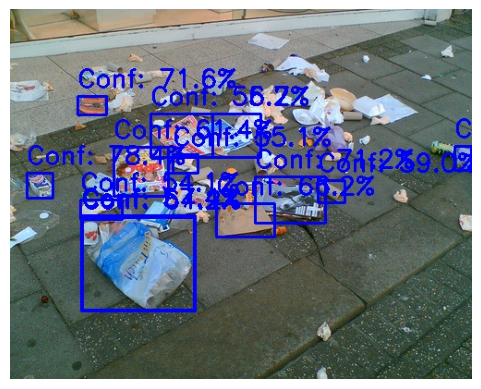

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Afficher l'image sauvegardée
image = Image.open("yolo_predictions.jpg")
plt.imshow(image)
plt.axis('off')  # Supprime les axes pour une meilleure visualisation
plt.show()


## 4. Algorithme qui utulise l' extraction des features du modele YOLYOV8 et fait le train de best model

### 4.1tester pour une image

In [ ]:
import cv2
from transformers import ViTFeatureExtractor, ViTModel
import torch
from PIL import Image

# Initialiser le modèle ViT et l'extracteur de caractéristiques
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)

def extract_features(image: Image.Image, feature_extractor, model):
    """
    Extrait les caractéristiques d'une image donnée en utilisant ViT.

    Args:
        image (PIL.Image): L'image d'entrée.
        feature_extractor: Extracteur de caractéristiques pour ViT.
        model: Modèle ViT pour l'extraction des caractéristiques.

    Returns:
        torch.Tensor: Les caractéristiques extraites de l'image.
    """
    # Appliquer l'extracteur de caractéristiques
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Passer les entrées dans le modèle ViT pour obtenir les caractéristiques
    with torch.no_grad():
        outputs = model(**inputs)

    # Retourner la dernière couche cachée comme les caractéristiques extraites
    return outputs.last_hidden_state.mean(dim=1)  # Moyenne des tokens pour simplification

def process_image(image_path, yolo_model, feature_extractor, model, best_model, visualize=True, output_path="labeled_output.jpg"):

    original_image_pil = Image.open(image_path).convert("RGB")
    results = yolo_model.predict(source=image_path, save=False, imgsz=640, conf=0.5)
    original_image_cv = cv2.imread(image_path)
    detections = []

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            cropped_img_pil = original_image_pil.crop((x1, y1, x2, y2))
            features = extract_features(cropped_img_pil, feature_extractor, model)
            features_np = features.detach().cpu().numpy()

            # Predict class and confidence
            pred_proba = best_model.predict_proba(features_np)[0]
            pred_class = pred_proba.argmax()
            confidence = pred_proba[pred_class]
            class_label = 'O' if pred_class == 0 else 'R'

            detection = {"bbox": (x1, y1, x2, y2), "class": class_label, "confidence": confidence}
            detections.append(detection)

            if visualize:
                color = (0, 255, 0) if class_label == 'O' else (0, 0, 255)
                cv2.rectangle(original_image_cv, (x1, y1), (x2, y2), color, 2)
                label = f"{class_label} ({confidence*100:.1f}%)"
                cv2.putText(original_image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    if visualize:
        cv2.imwrite(output_path, original_image_cv)
        print(f"Visualization saved to {output_path}")

    return detections



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import joblib
print("Loading YOLO model...")
yolo_model = YOLO('/content/yolov8-segment-trash-detection/yolov8m-seg.pt')


best_model = joblib.load("/content/best_model.pkl")

model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTModel.from_pretrained(model_name)
#input_image_path="hanouk.jpeg"
input_image_path = "/content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/f7c31030-679c-11e5-90f4-40f2e96c8ad8.jpg"
print(f"Processing image: {input_image_path}")

results = process_image(
    image_path=input_image_path,
    yolo_model=yolo_model,
    feature_extractor=feature_extractor,  # Correct argument
    model=model,                          # Include the ViT model
    best_model=best_model,
    visualize=True,
    output_path="labeled_output.jpg"
)




Loading YOLO model...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transform

Processing image: /content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/f7c31030-679c-11e5-90f4-40f2e96c8ad8.jpg

image 1/1 /content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/f7c31030-679c-11e5-90f4-40f2e96c8ad8.jpg: 512x640 2 Metals, 8 Papers, 3 Plastics, 36.5ms
Speed: 3.1ms preprocess, 36.5ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)
Visualization saved to labeled_output.jpg


In [ ]:
for idx, det in enumerate(results):
    print(f"Detection {idx+1}:")
    print(f"  Bounding Box: {det['bbox']}")
    print(f"  Class: {det['class']}")
    if det['confidence'] is not None:
        print(f"  Confidence: {det['confidence']*100:.2f}%")
    print()


Detection 1:
  Bounding Box: (18, 177, 46, 204)
  Class: R
  Confidence: 54.00%

Detection 2:
  Bounding Box: (73, 94, 104, 114)
  Class: O
  Confidence: 54.00%

Detection 3:
  Bounding Box: (265, 181, 341, 231)
  Class: R
  Confidence: 56.00%

Detection 4:
  Bounding Box: (223, 210, 286, 246)
  Class: O
  Confidence: 54.00%

Detection 5:
  Bounding Box: (78, 225, 199, 325)
  Class: R
  Confidence: 79.00%

Detection 6:
  Bounding Box: (112, 149, 171, 202)
  Class: R
  Confidence: 59.00%

Detection 7:
  Bounding Box: (333, 185, 362, 209)
  Class: R
  Confidence: 71.00%

Detection 8:
  Bounding Box: (77, 223, 200, 326)
  Class: R
  Confidence: 73.00%

Detection 9:
  Bounding Box: (481, 148, 499, 174)
  Class: O
  Confidence: 50.00%

Detection 10:
  Bounding Box: (152, 113, 271, 160)
  Class: R
  Confidence: 53.00%

Detection 11:
  Bounding Box: (152, 113, 219, 160)
  Class: R
  Confidence: 64.00%

Detection 12:
  Bounding Box: (176, 157, 203, 177)
  Class: O
  Confidence: 60.00%

Detecti

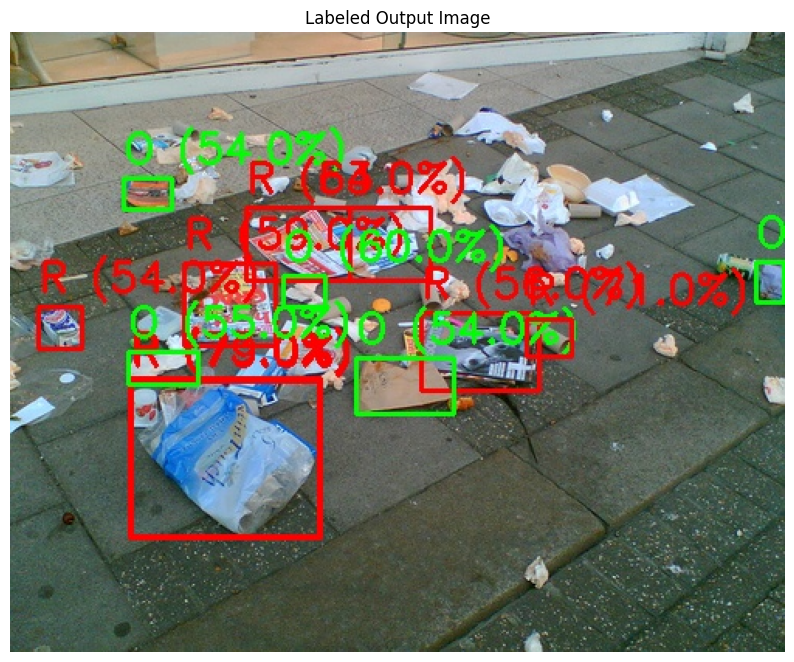

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the generated image
output_image_path = "labeled_output.jpg"
output_image = cv2.imread(output_image_path)

# Convert the image from BGR to RGB (OpenCV loads images in BGR format)
output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

# Plot the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(output_image_rgb)
plt.axis("off")  # Hide the axes for better visualization
plt.title("Labeled Output Image")
plt.show()


### 4.1tester pour des images dans un folder

In [ ]:
import os
from PIL import Image
import cv2

def process_folder(folder_path, yolo_model, feature_extractor, model, best_model, visualize=True, output_folder="labeled_outputs"):
    """


    Args:
        folder_path (str): Path to the folder containing images.
        yolo_model: YOLO model instance for prediction.
        feature_extractor: Feature extractor model.
        model: Model for extracting deep features.
        best_model: Pre-trained XGBoost classifier.
        visualize (bool): Whether to visualize and save results.
        output_folder (str): Folder to save labeled images.

    Returns:
        dict: Dictionary mapping image filenames to detections.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Crée le dossier de sortie s'il n'existe pas

    all_detections = {}

    # Parcourir chaque fichier dans le dossier
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):  # Filtrer les images
            image_path = os.path.join(folder_path, filename)
            original_image_pil = Image.open(image_path).convert("RGB")
            results = yolo_model.predict(source=image_path, save=False, imgsz=640, conf=0.5)
            original_image_cv = cv2.imread(image_path)
            detections = []

            for result in results:
                for box in result.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                    cropped_img_pil = original_image_pil.crop((x1, y1, x2, y2))
                    features = extract_features(cropped_img_pil, feature_extractor, model)
                    features_np = features.detach().cpu().numpy()

                    # Predict class and confidence
                    pred_proba = best_model.predict_proba(features_np)[0]
                    pred_class = pred_proba.argmax()
                    confidence = pred_proba[pred_class]
                    class_label = 'O' if pred_class == 0 else 'R'

                    detection = {"bbox": (x1, y1, x2, y2), "class": class_label, "confidence": confidence}
                    detections.append(detection)

                    if visualize:
                        color = (0, 255, 0) if class_label == 'O' else (0, 0, 255)
                        cv2.rectangle(original_image_cv, (x1, y1), (x2, y2), color, 2)
                        label = f"{class_label} ({confidence*100:.1f}%)"
                        cv2.putText(original_image_cv, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

            # Sauvegarder l'image avec les annotations
            if visualize:
                output_path = os.path.join(output_folder, filename)
                cv2.imwrite(output_path, original_image_cv)
                print(f"Visualization saved to {output_path}")

            # Ajouter les détections pour l'image actuelle
            all_detections[filename] = detections

    return all_detections


In [ ]:
# Example usage
input_folder = "/content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter"
output_folder = "output"
process_folder(input_folder, yolo_model, feature_extractor, model, best_model, output_folder=output_folder)



image 1/1 /content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/611fb088-679d-11e5-90f4-40f2e96c8ad8.jpg: 640x448 2 Plastics, 55.5ms
Speed: 2.7ms preprocess, 55.5ms inference, 63.0ms postprocess per image at shape (1, 3, 640, 448)
Visualization saved to output/611fb088-679d-11e5-90f4-40f2e96c8ad8.jpg

image 1/1 /content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/8207f620-679d-11e5-90f4-40f2e96c8ad8.jpg: 640x608 1 Paper, 1 Plastic, 50.2ms
Speed: 3.1ms preprocess, 50.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)
Visualization saved to output/8207f620-679d-11e5-90f4-40f2e96c8ad8.jpg

image 1/1 /content/extracted_files/spotgarbage-GINI-master/spotgarbage/garbage-queried-images/street litter/3fc8a174-679d-11e5-90f4-40f2e96c8ad8.jpg: 640x480 4 Papers, 87.4ms
Speed: 3.6ms preprocess, 87.4ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)
Visualization saved to out

{'611fb088-679d-11e5-90f4-40f2e96c8ad8.jpg': [{'bbox': (217, 524, 345, 590),
   'class': 'O',
   'confidence': 0.66},
  {'bbox': (226, 170, 348, 272), 'class': 'O', 'confidence': 0.75}],
 '8207f620-679d-11e5-90f4-40f2e96c8ad8.jpg': [{'bbox': (236, 323, 279, 354),
   'class': 'R',
   'confidence': 0.59},
  {'bbox': (299, 237, 330, 249), 'class': 'O', 'confidence': 0.53}],
 '3fc8a174-679d-11e5-90f4-40f2e96c8ad8.jpg': [{'bbox': (522, 794, 617, 858),
   'class': 'R',
   'confidence': 0.54},
  {'bbox': (581, 979, 762, 1048), 'class': 'O', 'confidence': 0.51},
  {'bbox': (552, 674, 666, 759), 'class': 'O', 'confidence': 0.53},
  {'bbox': (306, 665, 376, 706), 'class': 'R', 'confidence': 0.61}],
 '71773618-679d-11e5-90f4-40f2e96c8ad8.jpg': [{'bbox': (129, 67, 208, 153),
   'class': 'O',
   'confidence': 0.53},
  {'bbox': (272, 45, 336, 103), 'class': 'O', 'confidence': 0.5},
  {'bbox': (279, 12, 480, 213), 'class': 'R', 'confidence': 0.74},
  {'bbox': (202, 82, 293, 149), 'class': 'R', 'confi

In [ ]:
import shutil

# Replace 'folder_name' with the path of the folder you want to download
shutil.make_archive('output', 'zip', 'output')


'/content/output.zip'